# Home Runs
```python
dfc["div_vibes"] = (dfc["batter_divinity"] * (1 + 0.2 * dfc["batter_vibes"])
                    * dfc["batter_multiplier"])
dfc["opw_vibes"] = (dfc["pitcher_overpowerment"] * (1 + 0.2 * dfc["pitcher_vibes"])
                    * dfc["pitcher_multiplier"])
dfc["supp_vibes"] = (dfc["pitcher_suppression"] * (1 + 0.2 * dfc["pitcher_vibes"])
                     * dfc["pitcher_multiplier"])

# "x_center" ballpark stats are x-0.5. coefficients in this grouping sum to 1.0
dfc["ballpark_sum"] = (
    0.4*dfc["grand_center"]
    + 0.2*dfc["fort_center"]
    + 0.08*dfc["visc_center"]
    + 0.08*dfc["om_center"]
    - 0.24*dfc["fwd_center"]
)
# 10:1 ratio of overpowerment to suppression
dfc["opw_supp"] = (10 * dfc["opw_vibes"] + 1 * dfc["supp_vibes"]) / 11

# if roll < threshold, it's a home run!
dfc["threshold"] = (
    0.12
    + 0.16 * dfc["div_vibes"]
    - 0.08 * dfc["opw_supp"]
    - 0.18 * dfc["ballpark_sum"]
)
```

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-hr.csv")
df = pd.concat((pd.read_csv(f, dtype={"runner_on_third_hh_name": "string",
                                      "batting_team_mods": "string",
                                      "runner_on_third_hh_mods": "string",
                                     "stadium_id": "string"}) for f in all_files), ignore_index=True)

# select season (zero indexed)
seasons = [11, 12, 13, 14]
df = df[df["season"].isin(seasons)]
len(df)

60498

In [2]:
dfc = df.copy()
# dfc["batter_mul"] = dfc.apply(get_batter_mul, axis=1)
# dfc["pitcher_mul"] = dfc.apply(get_pitcher_mul, axis=1)

# dfc = dfc[dfc["stadium_id"].isna()]

for exclude_mod in ["ON_FIRE", "CHUNKY", "SMOOTH", "GROWTH", "TRAVELING"]:
    # for exclude_mod in ["O_NO", "ON_FIRE", "OVERPERFORMING", "UNDERPERFORMING",
    #                     "GROWTH", "HIGH_PRESSURE", "SINKING_SHIP", "TRAVELING", "CHUNKY", "SMOOTH"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

batter_params = [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_patheticism",
    "batter_thwackability",
    "batter_tragicness",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]
pitcher_params = [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]
# for attr in batter_params:
#     dfc[attr] = dfc[attr] * dfc["batter_mul"]
# for attr in pitcher_params:
#     dfc[attr] = dfc[attr] * dfc["pitcher_mul"]

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

# dfc = dfc[dfc["batter_mul"] == 1]
# dfc = dfc[dfc["pitcher_mul"] == 1]
len(dfc)

49405

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

dfc["grand_center"] = dfc["ballpark_grandiosity"] - 0.5
dfc["fort_center"] = dfc["ballpark_fortification"] - 0.5
dfc["obt_center"] = dfc["ballpark_obtuseness"] - 0.5
dfc["om_center"] = dfc["ballpark_ominousness"] - 0.5
dfc["inc_center"] = dfc["ballpark_inconvenience"] - 0.5
dfc["visc_center"] = dfc["ballpark_viscosity"] - 0.5
dfc["fwd_center"] = dfc["ballpark_forwardness"] - 0.5
dfc["myst_center"] = dfc["ballpark_mysticism"] - 0.5
dfc["elong_center"] = dfc["ballpark_elongation"] - 0.5

dfc["div_vibes"] = dfc["batter_divinity"] * (1 + 0.2 * dfc["batter_vibes"]) * dfc["batter_multiplier"]
dfc["opw_vibes"] = dfc["pitcher_overpowerment"] * (1 + 0.2 * dfc["pitcher_vibes"]) * dfc["pitcher_multiplier"]
dfc["supp_vibes"] = dfc["pitcher_suppression"] * (1 + 0.2 * dfc["pitcher_vibes"]) * dfc["pitcher_multiplier"]

# dfc["visc_om"] = dfc["visc_center"] + dfc["om_center"]
# dfc["visc_om_fwd"] = dfc["visc_om"] - 3*dfc["fwd_center"]
# dfc["grand_fort"] = 2*dfc["grand_center"] + dfc["fort_center"]
# dfc["ballpark_sum"] = dfc["grand_fort"] * 0.715 + dfc["visc_om_fwd"] * 0.285

dfc["ballpark_sum"] =(
    0.40*dfc["grand_center"]
    + 0.20*dfc["fort_center"]
    + 0.08*dfc["visc_center"]
    + 0.08*dfc["om_center"]
    - 0.24*dfc["fwd_center"]
)
dfc["opw_supp"] = (10 * dfc["opw_vibes"] + 1 * dfc["supp_vibes"])/11


X = dfc[
    [
        "roll",
        "div_vibes",
        "opw_supp",
        # "opw_vibes",
        # "supp_vibes",
        # "grand_fort",
        # "fort_center",
        # "fwd_center",
        # "visc_center",
        # "om_center",
        "ballpark_sum",
    ]
].copy()
y = dfc["passed"]

pin_intercept = 0.12
# pin_intercept = None
pins = [
    (0.16, "div_vibes"),
    # (-0.0725, "opw_vibes"),
    # (-0.00775, "supp_vibes"),
    # (0.0415, "fwd_center"),
    # (-0.0145, "visc_center"),
    # (-0.0725, "grand_center"),
    # (-0.0375, "fort_center"),
    # (-0.012, "om_center"),
    (-0.18, "ballpark_sum")
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=100000000, tol=1e-12,
                           fit_intercept=pin_intercept is None).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))
confusion_matrix(y, predictionsvm)

40270
9135


array([[40270,     0],
       [    0,  9135]])

In [4]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if pair[1] not in ["roll", "roll_pow"]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

dfc["threshold"] = (
    0.12
    + 0.16 * dfc["div_vibes"]
    - 0.08 * dfc["opw_supp"]
    - 0.18 * dfc["ballpark_sum"]
)
# 0.4 grand, 0.2 fort, 0.25? fwd, 0.085 visc, 

intercept: 0.12
(0.16, 'div_vibes')
(-0.18, 'ballpark_sum')
(-0.07996157889663481, 'opw_supp')


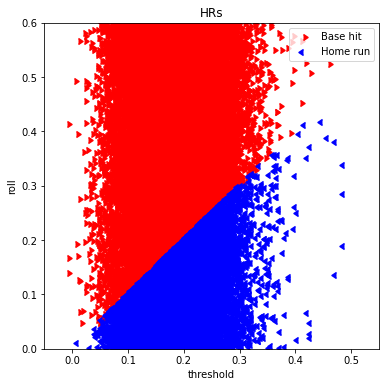

In [5]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Base hit",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Home run",
    marker=CARETLEFTBASE,
)
# ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title("HRs")
ax.set_xlim([-0.05, 0.55])
ax.set_ylim([0.0, 0.6])
ax.legend(loc="upper right")

0


,event_type,roll,passed,batter_buoyancy,batter_divinity,batter_martyrdom,batter_moxie,batter_musclitude,batter_patheticism,batter_thwackability,batter_tragicness,batter_coldness,batter_overpowerment,batter_ruthlessness,batter_shakespearianism,batter_suppression,batter_unthwackability,batter_base_thirst,batter_continuation,batter_ground_friction,batter_indulgence,batter_laserlikeness,batter_anticapitalism,batter_chasiness,batter_omniscience,batter_tenaciousness,batter_watchfulness,batter_pressurization,batter_cinnamon,batter_multiplier,runner_on_first_base_thirst,runner_on_first_continuation,runner_on_first_ground_friction,runner_on_first_indulgence,runner_on_first_laserlikeness,runner_on_first_multiplier,runner_on_second_base_thirst,runner_on_second_continuation,runner_on_second_ground_friction,runner_on_second_indulgence,runner_on_second_laserlikeness,runner_on_second_multiplier,runner_on_third_base_thirst,runner_on_third_continuation,runner_on_third_ground_friction,runner_on_third_indulgence,runner_on_third_laserlikeness,runner_on_third_multiplier,runner_on_third_hh_base_thirst,runner_on_third_hh_continuation,runner_on_third_hh_ground_friction,runner_on_third_hh_indulgence,runner_on_third_hh_laserlikeness,runner_on_third_hh_multiplier,pitcher_buoyancy,pitcher_divinity,pitcher_martyrdom,pitcher_moxie,pitcher_musclitude,pitcher_patheticism,pitcher_thwackability,pitcher_tragicness,pitcher_ruthlessness,pitcher_overpowerment,pitcher_unthwackability,pitcher_shakespearianism,pitcher_suppression,pitcher_coldness,pitcher_base_thirst,pitcher_continuation,pitcher_ground_friction,pitcher_indulgence,pitcher_laserlikeness,pitcher_anticapitalism,pitcher_chasiness,pitcher_omniscience,pitcher_tenaciousness,pitcher_watchfulness,pitcher_pressurization,pitcher_cinnamon,pitcher_multiplier,fielder_anticapitalism,fielder_chasiness,fielder_omniscience,fielder_tenaciousness,fielder_watchfulness,fielder_multiplier,ballpark_grandiosity,ballpark_fortification,ballpark_obtuseness,ballpark_ominousness,ballpark_inconvenience,ballpark_viscosity,ballpark_forwardness,ballpark_mysticism,ballpark_elongation,ballpark_filthiness,what1,what2,batting_team_hype,pitching_team_hype,batter_name,pitcher_name,fielder_name,runner_on_first_name,runner_on_second_name,runner_on_third_name,runner_on_third_hh_name,batter_vibes,pitcher_vibes,fielder_vibes,runner_on_first_vibes,runner_on_second_vibes,runner_on_third_vibes,runner_on_third_hh_vibes,batter_mods,batting_team_mods,pitcher_mods,pitching_team_mods,fielder_mods,runner_on_first_mods,runner_on_second_mods,runner_on_third_mods,runner_on_third_hh_mods,game_id,stadium_id,play_count,weather,ball_count,strike_count,out_count,season,day,top_of_inning,home_score,away_score,inning,batting_team_roster_size,pitching_team_roster_size,baserunner_count,baserunners,baserunners_next,is_strike,strike_roll,strike_threshold,fielder_roll,batter_consecutive_hits,grand_center,fort_center,obt_center,om_center,inc_center,visc_center,fwd_center,myst_center,elong_center,div_vibes,opw_vibes,supp_vibes,ballpark_sum,opw_supp,threshold,offset


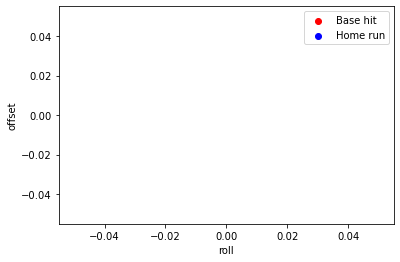

In [6]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "roll"
y_val = "offset"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]][y_val],
    color="red",
    label="Base hit",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]][y_val],
    color="blue",
    label="Home run"
)
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()
print(len(outliers))
table = outliers
# ax.set_yscale("log")
# ax.set_ylim(-0.5e-2, 0.5e-2)
pd.set_option("display.max_columns", None)
table

In [7]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.4166500940357283
0.0465922773929177


In [8]:
print(dfc["threshold"].min())
print(dfc["threshold"].argmin())
dfc.iloc[dfc["threshold"].argmin(), :]

-0.009940372689790821
13995


event_type          BaseHit
roll               0.414445
passed                False
batter_buoyancy    0.555156
batter_divinity    0.148398
                     ...   
supp_vibes         1.850148
ballpark_sum       0.102709
opw_supp           1.671626
threshold          -0.00994
offset             0.424385
Name: 17029, Length: 163, dtype: object

In [9]:
# dfc.loc[
#     :,
#     [
#         "offset",
#         "weather",
#         "event_type",
#         "roll",
#         "threshold",
#         "div_vibes",
#         "opw_vibes",
#         "supp_vibes",
#         "baserunner_count",
#         "batter_vibes",
#         "pitcher_vibes",
#         "batter_divinity",
#         "batter_name",
#         "pitcher_name",
#         "batter_mods",
#         "pitcher_mods",
#         "batter_mul",
#         "pitcher_mul",
#         "batting_team_mods",
#         "pitching_team_mods",
#         "day",
#         "game_id",
#         "play_count",
#     ],
# ]

In [10]:
# fwd = dfc["ballpark_forwardness"]
# obt = dfc["ballpark_obtuseness"]
# filth = dfc["ballpark_filthiness"]
# grand = dfc["ballpark_grandiosity"]
# fort = dfc["ballpark_fortification"]
# visc = dfc["ballpark_viscosity"]
# omin = dfc["ballpark_ominousness"]

# div = dfc["batter_divinity"] * (1 + 0.2 * dfc["batter_vibes"])

# ruth = dfc["pitcher_ruthlessness"] * (1 + 0.2 * dfc["pitcher_vibes"])
# opw = dfc["pitcher_overpowerment"] * (1 + 0.2 * dfc["pitcher_vibes"])
# supp = dfc["pitcher_suppression"] * (1 + 0.2 * dfc["pitcher_vibes"])

# # dfc["threshold"] = 0.1464 + 0.16*div - 0.0743*opw - 0.0725*grand + 0.049*fwd - 0.0332*fort

# dfc["threshold"] = -intercept_scaled
# print(-intercept_scaled)
# for pair in zip(-np.array(coef_list), X.columns):
#     if pair[1] != "roll":
#         print(pair)
#         if "sq" in pair[1]:
#             print(np.sqrt(pair[0]))
#         dfc["threshold"] += pair[0] * dfc[pair[1]]

# # dfc['threshold'] = 0.167 + 0.159*div - 0.072*opw - 0.008*supp
# # dfc['threshold'] += - 0.074*grand - 0.0375*fort + 0.0425*fwd - 0.012*visc - 0.01*omin


# # dfc["threshold"] = 0.159bu + 0.158*div - 0.0725*opw - 0.0075*supp - 0.075*grand - 0.038*fort + 0.05*fwd - 0.008*visc
# # dfc["threshold"] = 0.165 + 0.159*div - 0.0724*opw - 0.008*supp - 0.0724*grand - 0.039*fort + 0.039*fwd - 0.014*visc

# # dfc["threshold"] = 0.165 + 0.159*div - 0.0724*opw - 0.008*supp - 0.0724*grand - 0.039*fort + 0.039*fwd - 0.014*visc
# # dfc["threshold"] = 0.16 + 0.165*div - 0.0725*opw - 0.008*supp - 0.0725*grand - 0.04*fort + 0.04*fwd - 0.0139*visc
# coefsum = -0.074 - 0.0375 + 0.0425 - 0.012 - 0.01
# print(round(coefsum, 6))
# print(round(0.5 * coefsum, 6))
# print("", 0.167)
# print("", round(0.5 * coefsum + 0.167, 6))